## Logistic Regression with SGD

To begin you first need to install all dependencies, using:

    pip install -r requirements.txt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from math import exp, log
import os
import pickle

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import hog

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from copy import deepcopy
import pandas as pd

In [2]:
%matplotlib inline

### load the dataset

In [3]:
### set your image dir here
IMAGE_DIR = "./data/"

In [4]:
def load_dataset(subset="train"):
    """
    1. subset = "train", "val", "test"
    2. About the dataset: in "train","val" subset, the first half of images are images of hands, the rest half are images of not-hand. 
    3. extract features from HoG
    """
    path = os.path.join(IMAGE_DIR, subset)
    name_list = os.listdir(path)
    print("Number of images in {}-set: {}".format(subset, len(name_list)))
    #HoG returns 324 features
    X = np.zeros(shape=(len(name_list), 324))

    if subset == "train" or subset == "val":
        #Make sure that we have equal number of positive and negative class images
        assert len(name_list)%2 == 0
        count = len(name_list)//2
        y = np.array(count*[1] + count*[0])
        for idx_true in range(count):
            img_name = os.path.join(path,str(idx_true)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_true, :] = vec
        
        for idx in range(count):
            idx_false = idx + count
            img_name = os.path.join(path,str(idx_false)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_false, :] = vec
        return X, y        
    else:
        for idx in range(len(name_list)):
            img_name = os.path.join(path, str(idx)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx, :] = vec
        return X

### load the data

In [5]:
X_train, y_train = load_dataset("train")
X_val, y_val = load_dataset("val")
X_test = load_dataset("test")

Number of images in train-set: 8170


/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of images in val-set: 2724
Number of images in test-set: 5542


### displaying images

In [6]:
def display(img_path):
    """
    visualize the img
    """
    img = io.imread(img_path)
    print(img_path)
    io.imshow(img)
    io.show()

./data/train/129.png


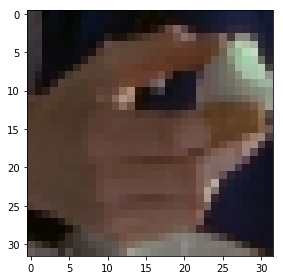

In [7]:
display(IMAGE_DIR+"train/129.png")

### Logistic regression

#### Main function in the class
1. \__init\__() which sets the hyper parameters
2. sigmoid()
3. __init_param(), initializes the parameters .
4. fit(): train the data
5. predict_proba(): predict the probability of the sample belonging to the positive class
6. predict(): classify the sample


Feel free to overlook the rest of the parts of the code, it's just for convenience.


In [85]:
class LogisticRegression:
    """
    Logistic Regression
    """
    def __init__(self, eta0=0.1, eta1=1, m=16, max_epoch=1000, delta=0.0001):
        """
        m is the batch_size
        """
        self.__init = True # whether to initial the parameters
        self.__eta0 = eta0
        self.__eta1 = eta1
        self.__delta = delta
        self.__m = m
        self.__max_epoch = max_epoch

        
    def sigmoid(self, x):
        return 1.0 / (1 + exp(-x))
    
    def __init_param(self):
        """
        Weights initialized using a normal distribution here: you can change the distribution.
        """
        np.random.seed(100)
        d = self.__dimension
        self.__wt = np.random.randn(1, d)
        self.__bias = np.random.randn()
        return self.__wt, self.__bias


    def visual_wt(self):
        '''visualize the weights
        '''
        pd.DataFrame(self.__wt[0]).hist(bins=15)


    def create_batch(self, n, m):
        '''Create batches of size m or m+1
        Parameters:
            n (int): the size of data set
            m (int): the size of the batch can be either m or m+1
        Return:
            (list): a list of batches, where each batch is a list
        '''
        permute = np.random.permutation(n)
        num_m_1 = n%m            # this number of batches have size of m+1
        num_m = n//m - num_m_1   # this number of batches have size of m
        batches = []
        index = 0
        for _ in range(num_m):
            batch = []
            for _ in range(m):
                batch.append(permute[index])
                index += 1
            batches.append(batch)
        for _ in range(num_m_1):
            batch = []
            for _ in range(m+1):
                batch.append(permute[index])
                index += 1
            batches.append(batch)
        return batches


    def loss_function(self, X_bar, y, thetaT):
        '''The loss function that we want to optimize
        Parameters:
            X_bar (ndarray, n=2): the training dataset
            thetaT (ndarray, n=1): the weights
        Return:
            (float)
        '''
        summation = 0
        for Xi, yi in zip(X_bar, y):
            summation += yi * thetaT @ Xi - log(1 + exp(thetaT @ Xi))
        return -summation/len(X_bar)


    def fit(self, X, y, filename_t, X_val=None, y_val=None, filename_v=None):
        """
        Recommended input:
        X: n x d array,
        y: n x 1 array or list
        """
        n, d = X.shape
        self.__dimension = d

        if self.__init:
            self.__init_param()

        ### write your code here ###
        train_file = open(filename_t, 'w')
        val_file = None
        if filename_v:
            val_file = open(filename_v, 'w')
        
        ones = np.array(np.ones(X.shape[0]))
        ones = np.expand_dims(ones, axis=0)
        X_bar = np.concatenate((X, ones.T), axis=1)         # X_bar.shape  = (n, d+1), i.e already transposed
        
        ones = np.array(np.ones(X_val.shape[0]))
        ones = np.expand_dims(ones, axis=0)
        X_val_bar = np.concatenate((X_val, ones.T), axis=1)
        
        thetaT = np.append(self.__wt[0], self.__bias)       # thetaT.shape = (d+1,)
        loss_old = self.loss_function(X_bar, y, thetaT)
        print(0, ',', loss_old, file=train_file)
        if filename_v:
            loss_val = self.loss_function(X_val_bar, y_val, thetaT)
            print(0, ',', loss_old, file=val_file)
        
        for epoch in range(1, self.__max_epoch+1):
            eta = self.__eta0/(self.__eta1 + epoch)         # eta decreases
            batches = self.create_batch(n, self.__m)
            new_thetaT = deepcopy(thetaT)
            for batch in batches:                           # batch is a list of random index
                derivative = np.zeros(len(thetaT))
                for i in range(len(batch)):
                    Xi = X_bar[batch[i]]
                    yi = y[batch[i]]
                    prob = self.sigmoid(new_thetaT @ Xi)
                    derivative += (yi - prob) * Xi
                derivative = -derivative/len(batch)          # take the average and times -1
                new_thetaT = new_thetaT - eta*derivative     # update thetaT
            
            loss_new = self.loss_function(X_bar, y, new_thetaT)
            #print(epoch, loss_old, loss_new, loss_new/loss_old)
            print(epoch, ',', loss_new, file=train_file)
            if filename_v:
                loss_val = self.loss_function(X_val_bar, y_val, new_thetaT)
                print(epoch, ',', loss_val, file=val_file)
            thetaT = deepcopy(new_thetaT)

            if loss_new < loss_old and loss_new > (1 - self.__delta)*loss_old:   # terminate condition
                print(self.__eta0, self.__eta1)
                print('epoch = ', epoch)
                print('loss  = ', loss_new)
                self.__wt = thetaT[0:d]
                self.__bias = thetaT[d]
                break

            loss_old = loss_new


    def fit2(self, X, y, filename_t, X_val, y_val, filename_v):
        """fit2 prints accuracy, instead of loss
        Recommended input:
        X: n x d array,
        y: n x 1 array or list
        """
        n, d = X.shape
        self.__dimension = d

        if self.__init:
            self.__init_param()

        ### write your code here ###
        train_file = open(filename_t, 'w')
        val_file = open(filename_v, 'w')
        
        ones = np.array(np.ones(X.shape[0]))
        ones = np.expand_dims(ones, axis=0)
        X_bar = np.concatenate((X, ones.T), axis=1)         # X_bar.shape  = (n, d+1), i.e already transposed
        
        ones = np.array(np.ones(X_val.shape[0]))
        ones = np.expand_dims(ones, axis=0)
        X_val_bar = np.concatenate((X_val, ones.T), axis=1)
        
        thetaT = np.append(self.__wt[0], self.__bias)       # thetaT.shape = (d+1,)
        accura_trian = self.accuracy(X_bar, y, thetaT)
        accura_val = self.accuracy(X_val_bar, y_val, thetaT)
        print(0, ',', accura_trian, file=train_file)
        print(0, ',', accura_val, file=val_file)
        
        loss_old = self.loss_function(X_bar, y, thetaT)

        for epoch in range(1, self.__max_epoch+1):
            eta = self.__eta0/(self.__eta1 + epoch)         # eta decreases
            batches = self.create_batch(n, self.__m)
            new_thetaT = deepcopy(thetaT)
            for batch in batches:                           # batch is a list of random index
                derivative = np.zeros(len(thetaT))
                for i in range(len(batch)):
                    Xi = X_bar[batch[i]]
                    yi = y[batch[i]]
                    prob = self.sigmoid(new_thetaT @ Xi)
                    derivative += (yi - prob) * Xi
                derivative = -derivative/len(batch)          # take the average and times -1
                new_thetaT = new_thetaT - eta*derivative     # update thetaT
            
            accura_trian = self.accuracy(X_bar, y, new_thetaT)
            accura_val = self.accuracy(X_val_bar, y_val, new_thetaT)
            #print(accura_trian, accura_val)
            print(epoch, ',', accura_trian, file=train_file)
            print(epoch, ',', accura_val, file=val_file)
            thetaT = deepcopy(new_thetaT)
            
            loss_new = self.loss_function(X_bar, y, new_thetaT)
            if loss_new < loss_old and loss_new > (1 - self.__delta)*loss_old:   # terminate condition
                print(self.__eta0, self.__eta1)
                print('epoch = ', epoch)
                print('loss = ', loss_new)
                print('accuracy train', accura_trian, '; accuracy val', accura_val)
                self.__wt = thetaT[0:d]
                self.__bias = thetaT[d]
                break

            loss_old = loss_new

    
    def predict(self, X):
        """
        Classify the sample
        """
        ones = np.array(np.ones(X.shape[0]))
        ones = np.expand_dims(ones, axis=0)
        X_bar = np.concatenate((X, ones.T), axis=1)         # X_bar.shape  = (8170, 325), i.e already transposed
        thetaT = np.append(self.__wt, self.__bias)       # thetaT.shape = (325,) # TODO, need to change dimensions here
        y_pred = []
        for Xi in X_bar:
            if self.sigmoid(thetaT @ Xi) >= 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
        return y_pred

    
    def accuracy(self, X_bar, y, thetaT):
        '''An metric other than the loss function
        Parameters:
            X (np.ndarray, n=2)
            y (list): a list of ground truth
            thetaT (np.ndarray, n=1)
        Return:
            (float): accuracy
        '''
        y_pred = []
        for Xi in X_bar:
            if self.sigmoid(thetaT @ Xi) >= 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)
        
        size = len(y_pred)
        count = 0
        for i in range(size):
            if y_pred[i] == y[i]:
                count += 1
        return float(count)/size
        

    def save_predicts(self, y_pred):
        df_pred = pd.DataFrame(y_pred, columns=['Class'])
        index = [i for i in range(0, len(df_pred))]
        df_pred.insert(0, 'Id', index)
        df_pred.to_csv('data/predTestClass.csv ', header=True, index=False)


    def get_param(self):
        """
        output:
            parameters: wt(1*d array), b(scalar)
        """
        return [self.__wt, self.__bias]
    
    def save_model(self, save_file):
        """
        save model to .pkl file
        """
        with open(save_file,"wb") as file:
            pickle.dump([self.__wt, self.__bias], file)

    def load_model(self, load_file):
        """
        load model from .pkl file
        """
        with open(load_file,"rb") as file:
            param = pickle.load(file)
        self.__wt = param[0]
        self.__bias = param[1]
        self.__init = False
        return self.__wt, self.__bias


## Question 2.3

### 1. Baseline Model

In [591]:
# default parameters, and np.random.seed(0)
LR = LogisticRegression()
LR.fit(X_train,y_train)

1 0.92199062195 0.674606636011 0.73168492168
2 0.674606636011 0.6581818893 0.975652853331
3 0.6581818893 0.646710144236 0.982570554963
4 0.646710144236 0.637945753791 0.986447730063
5 0.637945753791 0.630959978257 0.989049577503
6 0.630959978257 0.625128439382 0.990757672316
7 0.625128439382 0.620205426259 0.992124797381
8 0.620205426259 0.615904319828 0.993065029345
9 0.615904319828 0.612127419397 0.993867715634
10 0.612127419397 0.60876560131 0.99450797664
11 0.60876560131 0.605741940739 0.995033128408
12 0.605741940739 0.602991642698 0.995459620911
13 0.602991642698 0.60047534303 0.995826974224
14 0.60047534303 0.598161302009 0.996146318001
15 0.598161302009 0.596022167901 0.996423817287
16 0.596022167901 0.594031834088 0.996660637942
17 0.594031834088 0.592173762176 0.996872100441
18 0.592173762176 0.590432887768 0.997060196652
19 0.590432887768 0.588795613251 0.997226993023
20 0.588795613251 0.587251988505 0.99737833518
21 0.587251988505 0.585792734709 0.997515114764
22 0.58579273

172 0.531932898579 0.531807153815 0.999763607846
173 0.531807153815 0.531682236211 0.999765107327
174 0.531682236211 0.531558147329 0.999766610818
175 0.531558147329 0.531434906386 0.999768151529
176 0.531434906386 0.531312482655 0.999769635511
177 0.531312482655 0.531190861407 0.999771092809
178 0.531190861407 0.531070066252 0.999772595572
179 0.531070066252 0.530950067337 0.999774043157
180 0.530950067337 0.530830813359 0.999775395116
181 0.530830813359 0.530712326481 0.999776789751
182 0.530712326481 0.530594590473 0.999778154752
183 0.530594590473 0.530477644016 0.999779593575
184 0.530477644016 0.530361439231 0.999780943105
185 0.530361439231 0.530245975109 0.999782291635
186 0.530245975109 0.530131227247 0.999783595035
187 0.530131227247 0.530017174845 0.999784860057
188 0.530017174845 0.52990387565 0.999786234861
189 0.52990387565 0.529791251515 0.999787463085
190 0.529791251515 0.529679327099 0.999788738648
191 0.529679327099 0.529568070654 0.999789955092
192 0.529568070654 0.5

342 0.517863741747 0.517807401513 0.999891206452
343 0.517807401513 0.517751267323 0.999891592531
344 0.517751267323 0.517695329715 0.999891960463
345 0.517695329715 0.517639571064 0.999892294468
346 0.517639571064 0.517584009759 0.999892664108
347 0.517584009759 0.517528632025 0.999893007254
348 0.517528632025 0.517473423628 0.99989332301
349 0.517473423628 0.51741841191 0.999893691704
350 0.51741841191 0.517363566537 0.999894001891
351 0.517363566537 0.517308918973 0.999894372996
352 0.517308918973 0.517254449695 0.999894706478
353 0.517254449695 0.517200160615 0.999895043763
354 0.517200160615 0.517146052926 0.999895383465
355 0.517146052926 0.517092127538 0.999895725032
356 0.517092127538 0.517038372881 0.999896044333
357 0.517038372881 0.516984801999 0.999896388963
358 0.516984801999 0.516931400813 0.99989670647
359 0.516931400813 0.516878163376 0.999897012568
360 0.516878163376 0.516825105688 0.999897349722
361 0.516825105688 0.516772215658 0.999897663581
362 0.516772215658 0.516

(a) Number of epochs till termination = **369**

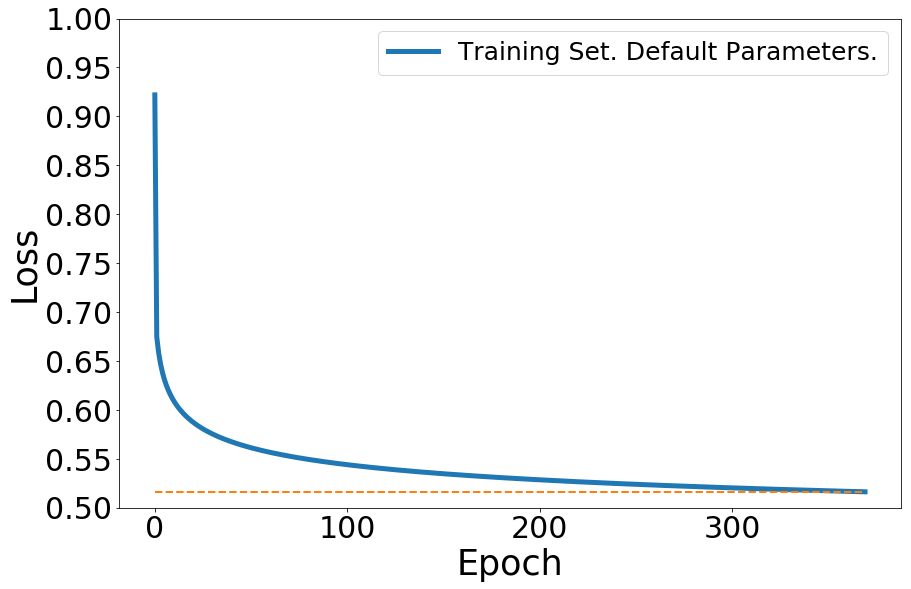

In [103]:
plt.figure(figsize=(14, 9))
rcParams['lines.linewidth'] = 5

SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 30
#
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

df_train = pd.read_csv('plot_data/q2_3_1.csv', header=None)
converge = np.array([0.516355139283 for i in range(len(df_train))])

X_epoch = df_train[0].tolist()
Y_train = df_train[1].tolist()

plt.plot(X_epoch, Y_train, linestyle='-')
plt.plot(X_epoch, converge, linestyle='--', linewidth=2)

plt.legend(['Training Set. Default Parameters.'], prop={'size':25})
plt.xlabel('Epoch', fontsize=35)
plt.ylabel('Loss', fontsize=35)
#plt.xlim([-1, 400])
plt.ylim([0.5, 1])
#plt.xticks(np.arange(50, 450, 50))
plt.yticks(np.arange(0.5, 1.01, 0.05))

plt.savefig('plot/q2_3_1_b.pdf')
plt.show()

(c) Final value of L($\theta$) after optimization = **0.516355139283**

### 2. Experimenting with ($\eta_0$,$\eta_1$)

In [686]:
#eta0s = [10, 50, 100, 200, 300, 400, 500, 600, 800, 1000]
#eta0s = [1, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 100]
eta0s = [1, 5, 10, 20, 40, 60, 80, 100, 200, 500]
eta1s = [1, 2, 5, 10, 20]

In [690]:
for eta0 in eta0s:
    for eta1 in eta1s:
        LR = LogisticRegression(eta0=eta0, eta1=eta1)
        LR.fit(X_train,y_train)
        print()

1 1
epoch =  292
loss  =  0.329850101768

1 2
epoch =  324
loss  =  0.333877239736

1 5
epoch =  383
loss  =  0.341175204502

1 10
epoch =  445
loss  =  0.34821305691

1 20
epoch =  524
loss  =  0.356802915788

5 1
epoch =  21
loss  =  0.292263122931

5 2
epoch =  60
loss  =  0.286634894051

5 5
epoch =  44
loss  =  0.298899580161

5 10
epoch =  95
loss  =  0.296996495858

5 20
epoch =  233
loss  =  0.294021750999

10 1
epoch =  85
loss  =  0.265782946135

10 2
epoch =  53
loss  =  0.270704673865

10 5
epoch =  63
loss  =  0.275183501061

10 10
epoch =  82
loss  =  0.278552168786

10 20
epoch =  100
loss  =  0.283871704056

20 1
epoch =  48
loss  =  0.257717126156

20 2
epoch =  48
loss  =  0.259731454561

20 5
epoch =  29
loss  =  0.267643360624

20 10
epoch =  50
loss  =  0.268390010482

20 20
epoch =  59
loss  =  0.273560769596

40 1
epoch =  103
loss  =  0.248195565231

40 2
epoch =  138
loss  =  0.248717978148

40 5
epoch =  138
loss  =  0.250744848806

40 10
epoch =  39
loss  =  

(a) Best value for, $\eta_0$ = **3**, $\eta_1$ = **1**

Number of epochs for training = **13**

Final value of L($\theta$) = **0.31952785732**

In [662]:
LR = LogisticRegression(eta0=3)
LR.fit(X_train,y_train)

3 1
epoch =  13
loss  =  0.31952785732


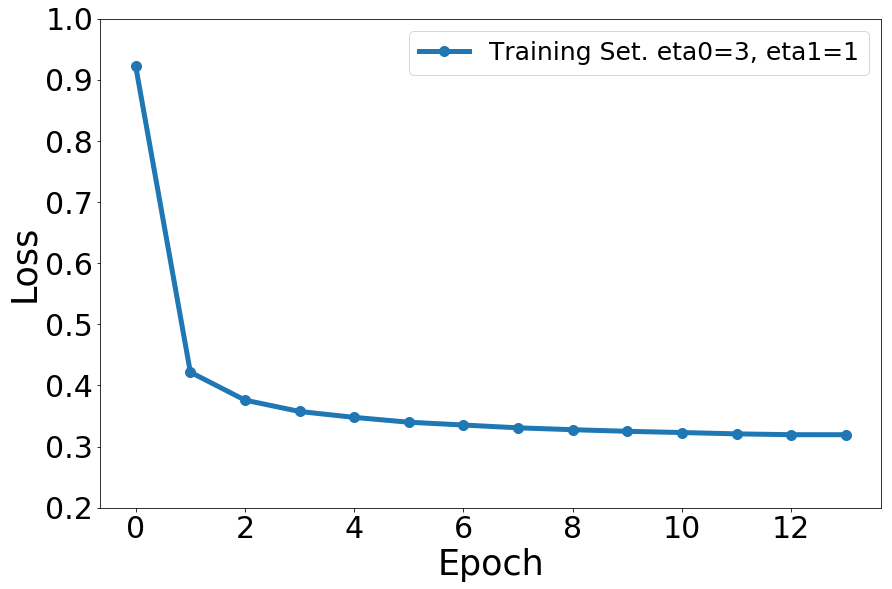

In [57]:
# (b) For best (eta_0, eta_1) plot L(theta) vs num_epochs
plt.figure(figsize=(14, 9))
rcParams['lines.linewidth'] = 5

SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 30
#
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

df_train = pd.read_csv('plot_data/q_.csv', header=None)

X_epoch = df_train[0].tolist()
Y_train = df_train[1].tolist()

plt.plot(X_epoch, Y_train, linestyle='-', marker='o', markersize=10)

plt.legend(['Training Set. eta0=3, eta1=1'], prop={'size':25})
plt.xlabel('Epoch', fontsize=35)
plt.ylabel('Loss', fontsize=35)
plt.ylim([0.5, 1])
plt.yticks(np.arange(0.2, 1.1, 0.1))

plt.savefig('plot/q2_3_2_b.pdf')
plt.show()

### 3. Evaluating on validation set

In [52]:
# (a) Plot L(theta) vs num_epochs for both training and validation set on the same figure
LR = LogisticRegression(eta0=500, m=16)
LR.fit(X_train, y_train, 'plot_data/q2_3_3_a_train.csv', X_val, y_val, 'plot_data/q2_3_3_a_val.csv')

500 1
epoch =  197
loss  =  0.229384054432


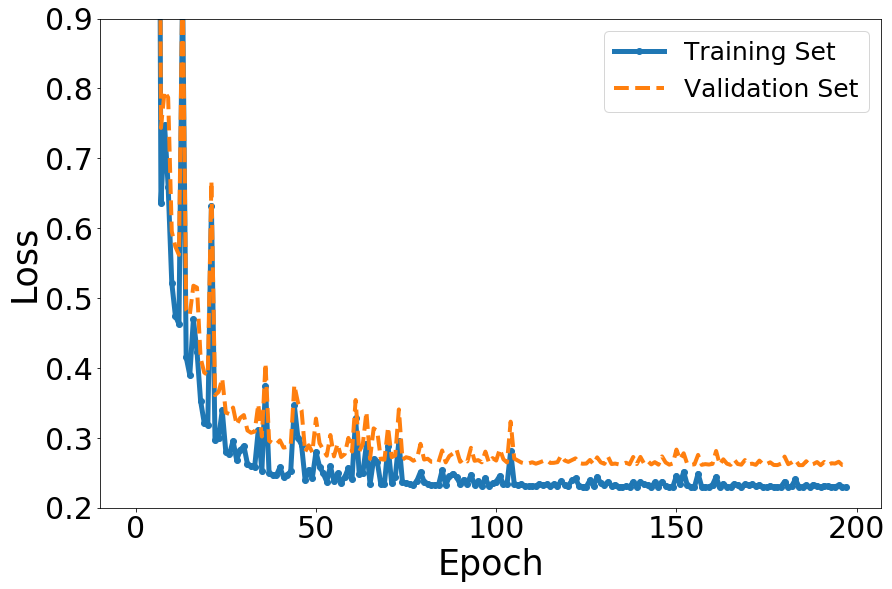

In [73]:
plt.figure(figsize=(14, 9))
rcParams['lines.linewidth'] = 5

SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 30
#
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

df_1 = pd.read_csv('plot_data/q2_3_3_a_train.csv', header=None)
df_2 = pd.read_csv('plot_data/q2_3_3_a_val.csv', header=None)

X_1 = df_1[0].tolist()
Y_1 = df_1[1].tolist()

X_2 = df_2[0].tolist()
Y_2 = df_2[1].tolist()

plt.plot(X_1, Y_1, linestyle='-', marker='o', markersize=6)
plt.plot(X_2, Y_2, linestyle='--', linewidth=4)

plt.legend(['Training Set', 'Validation Set'], prop={'size':25})
plt.xlabel('Epoch', fontsize=35)
plt.ylabel('Loss', fontsize=35)
plt.yticks(np.arange(0.2, 1.0, 0.1))
plt.ylim([0.2, 0.9])
plt.savefig('plot/q2_3_3_a2.pdf')
plt.show()

In [88]:
# (b) Plot Accuracy vs num_epochs for both training and validation set on the same figure
LR = LogisticRegression(eta0=500, m=16)
LR.fit2(X_train, y_train, 'plot_data/q2_3_3_b_train.csv', X_val, y_val, 'plot_data/q2_3_3_b_val.csv')

500 1
epoch =  197
loss =  0.229384054432
accuracy train 0.909547123623011 ; accuracy val 0.8928046989720999


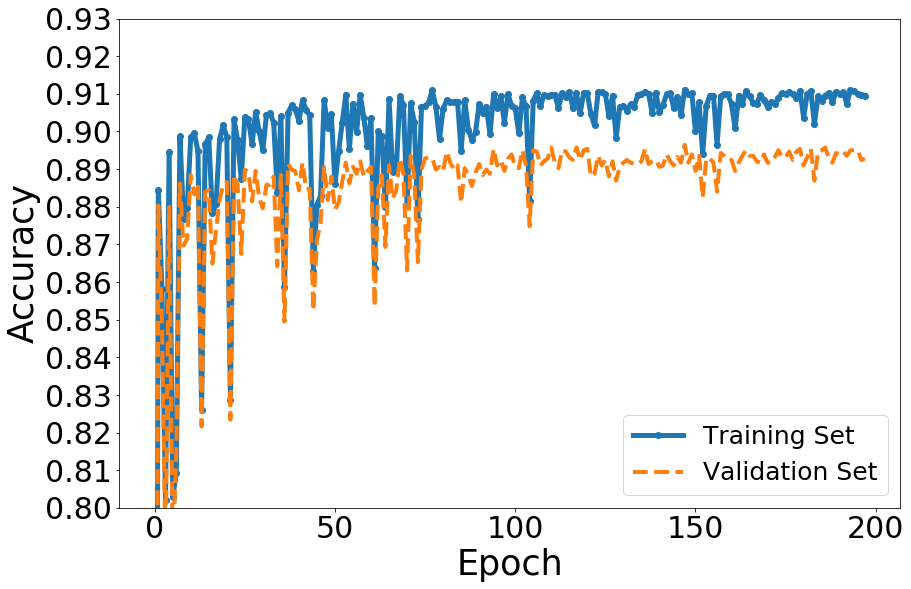

In [100]:
plt.figure(figsize=(14, 9))
rcParams['lines.linewidth'] = 5

SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 30
#
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

df_1 = pd.read_csv('plot_data/q2_3_3_b_train.csv', header=None)
df_2 = pd.read_csv('plot_data/q2_3_3_b_val.csv', header=None)

X_1 = df_1[0].tolist()
Y_1 = df_1[1].tolist()

X_2 = df_2[0].tolist()
Y_2 = df_2[1].tolist()

plt.plot(X_1, Y_1, linestyle='-', marker='o', markersize=6)
plt.plot(X_2, Y_2, linestyle='--', linewidth=4)

plt.legend(['Training Set', 'Validation Set'], prop={'size':25})
plt.xlabel('Epoch', fontsize=35)
plt.ylabel('Accuracy', fontsize=35)
plt.yticks(np.arange(0.8, 0.94, 0.01))
plt.ylim([0.8, 0.93])
plt.savefig('plot/q2_3_3_b2.pdf')
plt.show()

### 4. ROC and Precision-Recall curves

In [ ]:
#(a) Plot ROC curve on validation data

Area under curve = __

In [ ]:
#(a) Plot Precision-Recall curve on validation data

In [ ]:
Average Precision = __

## Question 2.4

### 1. Submission

In [ ]:
import pandas as pd
def submission(y_pred):
    """
    generate the submission.csv for kaggle
    input args:
        y_pred: 5542x1 array or list contains 5542 elements
        
    """
    save_file = pd.DataFrame(columns=["Id","Class"])
    id = np.array([idx for idx in range(5542)])
    save_file["Id"] = id
    save_file["Class"]= y_pred
    save_file.to_csv("submission.csv",index=0)       

#### Generate the submission.csv

In [652]:
LR = LogisticRegression(eta0=500)
LR.fit(X_train,y_train)

500 1
epoch =  197
loss  =  0.229384054432


In [653]:
y_pred = LR.predict(X_test)
LR.save_predicts(y_pred)

Best obtained accuracy on Public Leader-board = __%